In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import os
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import skimage.io as io
import skimage.transform as trans
import shutil

from skimage import data

In [9]:
# ejecutar una sola vez
import shutil

# borramos los directorios demo creados hasta ahora para hacer las pruebas
# shutil.rmtree('CASIA_Cropped')
# shutil.rmtree('CASIA_Edge')
# shutil.rmtree('CASIA_Segmented')
# shutil.rmtree('CASIA_Segmented_v2')
# shutil.rmtree('CASIA_v1')

In [10]:
# shutil.rmtree('CASIA-Iris-Segmented')
# shutil.rmtree('U-net Output')

In [11]:
def create_segmented_dir(from_dir, to_dir):
    '''
    Crea la mimsma estructura con la que cuenta el dataset de CASIA en la que se guardará 
    las imágenes segmentadas.
    '''
    # creamos carpeta en la que guardaremos las imágenes
    os.mkdir(to_dir)
    for i in range(1, len(os.listdir(from_dir))+1): # 108 sujetos
        sample = to_dir + os.sep + "%.3d" % i
        os.mkdir(sample)
        for j in range(1,3): # 2 sesiones
            session = sample + os.sep + str(j)
            os.mkdir(session)
                   
    print("-> Estructura de directorios creados satisfactoriamente.")

create_segmented_dir('CASIA-IrisV1', 'CASIA-Iris-Segmented')

-> Estructura de directorios creados satisfactoriamente.


In [12]:
def get_paths(directory, last_element=False):
    '''
    Devuelve la ruta relativa de las muestras .bmp
    '''
    paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".bmp"):
                if last_element:
                    paths.append(str(file))
                else:
                    paths.append(os.path.join(root, file))
    return paths

In [13]:
original_paths = get_paths("CASIA-IrisV1") # paths de las muestras originales del dataset CASIA
samples_names = get_paths("CASIA-IrisV1",True) # nombre de las muestras y su extensión
original = [cv2.imread(muestra,0) for muestra in original_paths] # en blanco y negro
# plt.imshow(original[0]);

In [14]:
def testGenerator(originals, target_size= (320,320)):
    for muestra in originals:
        img = muestra / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,(1,)+img.shape)
        yield img

def saveResult(results, save_dir, names_results):
    '''
    Guarda los imágenes segmentadas resultado de la red preentrenada
    
    Parámetros:
    results -- resultado de la red preentrenada
    save_path -- ruta en la que se guardarán las muestras segmentadas
    name_path -- directorio del que cogeremos los nombres de las muestras
    
    flag_multi_class -- (de momento mantener pero no nos es útil)
    '''
    dim = (320, 280) # dimensiones de las muestras del dataset
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
        for i,item in enumerate(results):
            img = item[:,:,0]
            img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            io.imsave(os.path.join(save_dir,names_results[i]),img)

In [16]:
from keras.models import load_model

model = load_model('Iris_unet_d5.h5')
# model.summary()

Using TensorFlow backend.


In [17]:
gen = testGenerator(original)
results = model.predict(gen,verbose=1)

756/756 [==============================] - 1026s 1s/step


In [18]:
# tiene que haber un directorio con las 756 muestras segmentadas
saveResult(results, "U-net Output", samples_names)

### Aplicamos los operadores morfológicos

Se harán sobre todas las muestras del directorio `U-net Output`

In [19]:
def morph_operator(images):
#     if os.path.isdir(save_dir):
#         shutil.rmtree(save_dir)
#     os.mkdir(save_dir)
#     outputs = [os.path.join(images_dir,muestra) for muestra in os.listdir(images_dir)]
#     outputs_names = [muestra for muestra in os.listdir(images_dir)]
#     i = 0
    enhanced = []
    for img in images:
#         img = cv2.imread(output)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
        (thresh, binRed) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY) # se binariza
        opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2) # se aplica operadores morfológicos(vigilar iteraciones)
        (thresh, binRed) = cv2.threshold(opening, 128, 255, cv2.THRESH_BINARY) # se binariza nuevamente
        # guardamos muestra mejorada
#         cv2.imwrite(os.path.join(save_dir, outputs_names[i]),binRed)
        enhanced.append(binRed)
#         i = i + 1
    return enhanced

outputs_unet = [cv2.imread(muestra,0) for muestra in get_paths("U-net Output")] # eliminar checkpoints
enhanced_outputs = morph_operator(outputs_unet)

In [20]:
def canny_edges(images):
#     if os.path.isdir(save_dir):
#         shutil.rmtree(save_dir)
#     os.mkdir(save_dir)
    
#     outputs = [os.path.join(images_dir,muestra) for muestra in os.listdir(images_dir)]
#     outputs_names = [muestra for muestra in os.listdir(images_dir)]
#     i = 0
    canny_edges = []
    for img in images:
        edges = cv2.Canny(img, 10, 255)
        # guardamos muestra mejorada
#         cv2.imwrite(os.path.join(save_dir, outputs_names[i]),edges)
        canny_edges.append(edges)
#         i = i + 1
    return canny_edges

canny_outputs = canny_edges(enhanced_outputs)

In [22]:
from skimage import data
from skimage.transform import (hough_line, hough_line_peaks, hough_circle, hough_circle_peaks)
from skimage.draw import circle_perimeter
from skimage.color import gray2rgb
from matplotlib import cm

def draw_circles(img, cx, cy, radii):
    '''
    A partir de los centros y el radio detectados dibuja el iris sobre la imagen que se le
    pasa como parámetro.
    '''
#     image = gray2rgb(img) # convertimos a color
#     for center_y, center_x, radius in zip(cy, cx, radii):
#         circy, circx = circle_perimeter(center_y, center_x, radius)
# #         print(image[circy,circx])
#         image[circy, circx] = (0, 255, 0) # green
    image = img
    pupil = cv2.circle(image,(cx[0],cy[0]), radii[0], (255, 0, 0), 2)
    iris = cv2.circle(image,(cx[1],cy[1]), radii[1], (255, 0, 0), 2)
    return image

In [23]:
# EJECUTAR UNA VEZ QUE TARDA MUCHO!!!
def get_centers_radius(canny_images, original_images, names):
#     outputs = [os.path.join(images_dir,muestra) for muestra in os.listdir(images_dir)]
#     outputs_names = [muestra for muestra in os.listdir(images_dir)]
    
    boundaries = dict() # contiene los bordes límbico y pupilar
    centers = dict() # contiene centros y radio de la pupila
    i = 0
    for img in canny_images:
        gray_img= img
        hough_radii = np.arange(20, 150, 2) # ajustar manualmente para que empiece desde un rango que incluya tanto al iris como a la pupila
        hough_res = hough_circle(gray_img, hough_radii)
        accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=2) # total_num_peaks -> nro de círculos
        x_pupil, x_iris = cx
        y_pupil, y_iris = cy
        radius_pupil, radius_iris = radii
        boundaries[names[i]] = draw_circles(original_images[i], cx, cy, radii)
        centers[names[i]] = dict()
        centers[names[i]]['pupil'] = [x_pupil, y_pupil, radius_pupil]
        centers[names[i]]['iris'] = [x_iris, y_iris, radius_iris]
        i = i+1
        
    print('DONE!')
    return boundaries, centers

boundaries, centers = get_centers_radius(canny_outputs, original, samples_names)

DONE!


In [41]:
pupil_centers = [c['pupil'] forº c in centers.values()]

In [57]:
def IrisNormalization(boundary,centers):
    normalized=boundary
    cent=0
    for name in normalized:
        img = normalized[name]
        #load pupil centers and radius of inner circles
        center_x = centers[cent][0]
        center_y = centers[cent][1]
        radius_pupil=int(centers[cent][2])
        
        iris_radius = 53 # width of space between inner and outer boundary
    
        #define equally spaced interval to iterate over
        nsamples = 360
        samples = np.linspace(0,2*np.pi, nsamples)[:-1]
        polar = np.zeros((iris_radius, nsamples))
        for r in range(iris_radius):
            for theta in samples:
                #get x and y for values on inner boundary
                x = (r+radius_pupil)*np.cos(theta)+center_x
                y = (r+radius_pupil)*np.sin(theta)+center_y
                x=int(x)
                y=int(y)
                try:
                #convert coordinates
                    polar[r][int((theta*nsamples)/(2*np.pi))] = img[y][x]
                except IndexError: #ignores values which lie out of bounds
                    pass
                continue
        res = cv2.resize(polar,(512,64))
        normalized[name] = res
        cent+=1
    return normalized #returns a list of 64x512 normalized images

normalized = IrisNormalization(boundaries, pupil_centers)

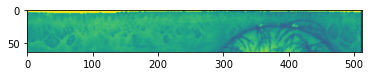

In [59]:
plt.imshow(normalized['003_2_1.bmp'])

In [70]:
normalized['003_2_1.bmp'].shape

(61, 256)

In [76]:
from skimage import exposure
def crop_and_ecualization(normalized):
    enhanced = normalized
    for e in enhanced:
        img = enhanced[e]
        h,w = img.shape
        roi = img[3:h, 0:int(512/2)]
#         roi_enhanced = cv2.equalize
#         enhanced[e] = roi
        roi_enhanced = exposure.equalize_hist(roi)
        enhanced[e] = roi_enhanced
        
    print("DONE!")
    return enhanced

polar = crop_and_ecualization(normalized)

DONE!


In [ ]:
saveResult(results, "U-net Output", samples_names)

In [78]:
# guardamos los trozos
name_folder = "Polar Outputs"
os.mkdir(name_folder)
for p in polar:
    img = polar[p]
    io.imsave(os.path.join(name_folder,p),img)